## Analysis of bid/ask spreads on orchids

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
import tools.log_parser as log_parser

In [4]:
sns.set_theme(style="whitegrid")

We have two sources of data.

The first is the log from our prober:

In [5]:
LOG_PATH = "prober.log"

<Axes: xlabel='timestamp'>

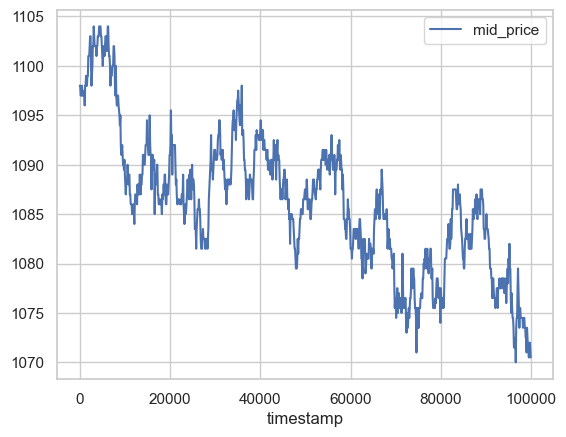

In [9]:
prober_logs = log_parser.parse_log(LOG_PATH)

activity_df = prober_logs.activity_df
orchid_df = activity_df[activity_df["product"] == "ORCHIDS"]

orchid_df.plot(x="timestamp", y="mid_price")

In [15]:
orchid_df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
1,1,0,ORCHIDS,1094,10,1093.0,3.0,1086.0,41.0,1102,10,1104.0,3.0,1111.0,41.0,1098.0,0.0
4,1,100,ORCHIDS,1094,6,1093.0,2.0,1087.0,51.0,1102,6,1103.0,2.0,1110.0,51.0,1098.0,0.0
7,1,200,ORCHIDS,1093,6,1092.0,3.0,1085.0,49.0,1101,6,1102.0,3.0,1108.0,49.0,1097.0,0.0
11,1,300,ORCHIDS,1093,10,1092.0,4.0,1085.0,52.0,1101,10,1102.0,4.0,1109.0,52.0,1097.0,0.0
13,1,400,ORCHIDS,1093,10,1092.0,3.0,1086.0,51.0,1101,10,1102.0,3.0,1109.0,51.0,1097.0,0.0


... and the second is the log files provided from the bottle.

In [10]:
ORCHID_PRICES_PATH = "../../data/data_v1/prices_2.csv"

<Axes: xlabel='timestamp'>

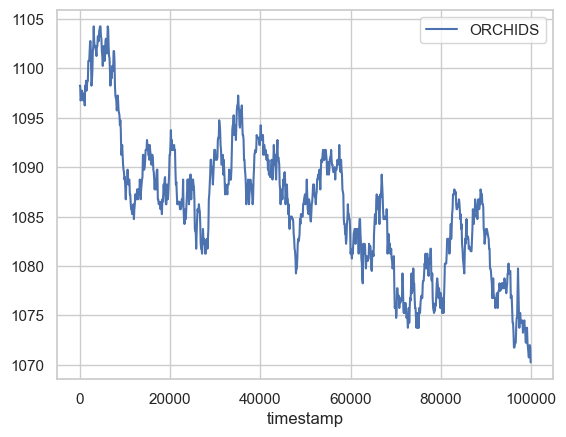

In [18]:
orchid_price_df = pd.read_csv(ORCHID_PRICES_PATH, sep=";")
orchid_price_df = orchid_price_df.query("DAY == 1 and timestamp < 100000")
orchid_price_df.plot(x="timestamp", y="ORCHIDS")

Both give different information: the bottle gives us the true price information, while the prober gives us the bot trades.

## Analysis

Let's check the differences between the bot bids/offers and the actual price.

In [51]:
order_prices = []
order_volumes = []
order_types = []
order_timestamps = []
for row in orchid_df.iloc:
    for i in range(1, 4):
        if row[f"bid_price_{i}"]:
            order_prices.append(row[f"bid_price_{i}"])
            order_volumes.append(row[f"bid_volume_{i}"])
            order_types.append("bid")
            order_timestamps.append(row["timestamp"])
        if row[f"ask_price_{i}"]:
            order_prices.append(row[f"ask_price_{i}"])
            order_volumes.append(row[f"ask_volume_{i}"])
            order_types.append("ask")
            order_timestamps.append(row["timestamp"])

order_df = pd.DataFrame({
    "timestamp": order_timestamps,
    "price": order_prices,
    "volume": order_volumes,
    "type": order_types
})
order_df.head(10)

,timestamp,price,volume,type
0,0,1094.0,10.0,bid
1,0,1102.0,10.0,ask
2,0,1093.0,3.0,bid
3,0,1104.0,3.0,ask
4,0,1086.0,41.0,bid
5,0,1111.0,41.0,ask
6,100,1094.0,6.0,bid
7,100,1102.0,6.0,ask
8,100,1093.0,2.0,bid
9,100,1103.0,2.0,ask


In [52]:
deviation_df = order_df.join(orchid_price_df[["timestamp", "ORCHIDS"]].set_index("timestamp"), on="timestamp")
deviation_df["delta"] = deviation_df["price"] - deviation_df["ORCHIDS"]
deviation_df.head(10)

,timestamp,price,volume,type,ORCHIDS,delta
0,0,1094.0,10.0,bid,1098.25,-4.25
1,0,1102.0,10.0,ask,1098.25,3.75
2,0,1093.0,3.0,bid,1098.25,-5.25
3,0,1104.0,3.0,ask,1098.25,5.75
4,0,1086.0,41.0,bid,1098.25,-12.25
5,0,1111.0,41.0,ask,1098.25,12.75
6,100,1094.0,6.0,bid,1098.25,-4.25
7,100,1102.0,6.0,ask,1098.25,3.75
8,100,1093.0,2.0,bid,1098.25,-5.25
9,100,1103.0,2.0,ask,1098.25,4.75


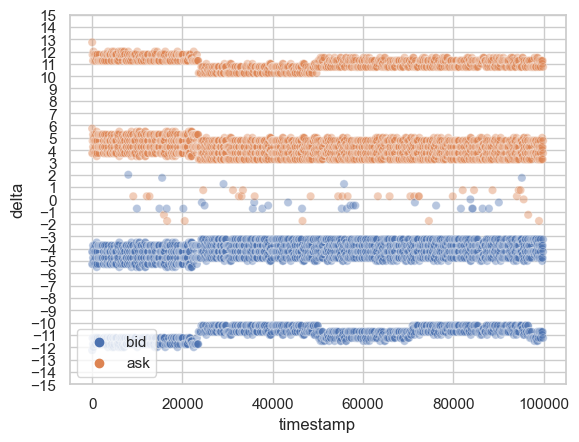

In [53]:
sns.scatterplot(data=deviation_df, x="timestamp", y="delta", hue="type", alpha=0.4)
plt.yticks(np.arange(-15, 16))
plt.legend(loc="lower left")

They separate cleanly into three tiers:

```
tier 2 bid
----------
tier 1 bid
----------
tier 0 bid/ask
----------
tier 1 ask
----------
tier 2 ask
```

These seem to be centered around 0/5/10.

In [63]:
DELTA1 = 2.5
DELTA2 = 7.5

def analyse_delta_types(df):
    df = df.copy()
    df["abs_delta"] = df["delta"].abs()
    tier_0 = df.query("abs_delta < @DELTA1")
    tier_1 = df.query("@DELTA1 <= abs_delta < @DELTA2")
    tier_2 = df.query("@DELTA2 <= abs_delta")
    print(f"Tier 0: {len(tier_0)}")
    print(f"Tier 1: {len(tier_1)}")
    print(f"Tier 2: {len(tier_2)}")
    return tier_0, tier_1, tier_2

print("Bids:")
bid_0, bid_1, bid_2 = analyse_delta_types(deviation_df.query("type == 'bid'"))
print("Asks:")
ask_0, ask_1, ask_2 = analyse_delta_types(deviation_df.query("type == 'ask'"))

Bids:
Tier 0: 31
Tier 1: 2000
Tier 2: 969
Asks:
Tier 0: 34
Tier 1: 2000
Tier 2: 966


Really weird! Exactly 2000 tier 1s in each. Note that the spread is always filled with 3 orders each side. Let's analyse further:

In [65]:
display(bid_1.head(10))
display(ask_1.head(10))

,timestamp,price,volume,type,ORCHIDS,delta,abs_delta
0,0,1094.0,10.0,bid,1098.25,-4.25,4.25
2,0,1093.0,3.0,bid,1098.25,-5.25,5.25
6,100,1094.0,6.0,bid,1098.25,-4.25,4.25
8,100,1093.0,2.0,bid,1098.25,-5.25,5.25
12,200,1093.0,6.0,bid,1096.75,-3.75,3.75
14,200,1092.0,3.0,bid,1096.75,-4.75,4.75
18,300,1093.0,10.0,bid,1097.00,-4.00,4.00
20,300,1092.0,4.0,bid,1097.00,-5.00,5.00
24,400,1093.0,10.0,bid,1097.25,-4.25,4.25
26,400,1092.0,3.0,bid,1097.25,-5.25,5.25


,timestamp,price,volume,type,ORCHIDS,delta,abs_delta
1,0,1102.0,10.0,ask,1098.25,3.75,3.75
3,0,1104.0,3.0,ask,1098.25,5.75,5.75
7,100,1102.0,6.0,ask,1098.25,3.75,3.75
9,100,1103.0,2.0,ask,1098.25,4.75,4.75
13,200,1101.0,6.0,ask,1096.75,4.25,4.25
15,200,1102.0,3.0,ask,1096.75,5.25,5.25
19,300,1101.0,10.0,ask,1097.00,4.00,4.00
21,300,1102.0,4.0,ask,1097.00,5.00,5.00
25,400,1101.0,10.0,ask,1097.25,3.75,3.75
27,400,1102.0,3.0,ask,1097.25,4.75,4.75


... so it seems like exactly two tier 1 orders in each timestamp. Let's confirm.

In [61]:
display(bid_1["timestamp"].value_counts().value_counts())
display(ask_1["timestamp"].value_counts().value_counts())

count
2    1000
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

## When do tier 0s happen?

c:\Users\Thien\miniconda3\envs\kaggle\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Thien\miniconda3\envs\kaggle\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Thien\miniconda3\envs\kaggle\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='timestamp'>

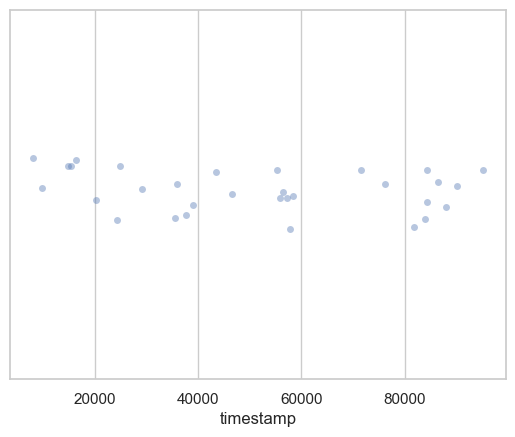

In [73]:
sns.stripplot(data=bid_0, x="timestamp", alpha=0.4)

<Axes: >

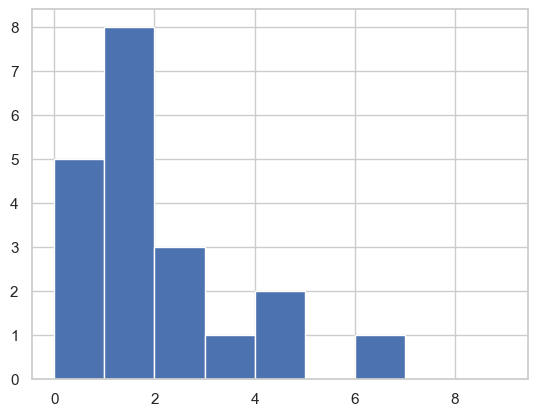

In [89]:
bin_width = 5000
bid_0_bins = bid_0.groupby(pd.cut(bid_0["timestamp"], np.arange(0, 100000 + bin_width, bin_width)), observed=False).size()
bid_0_bins.hist(bins=np.arange(0, 10))

seems random enough, too lazy to do a formal test